<a href="https://colab.research.google.com/github/nishuchy/AI-works/blob/main/Ethereum_Preictive_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
import shutil

# Remove existing contents from the mountpoint
if os.path.exists('/content/drive'):
  shutil.rmtree('/content/drive')

drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


**Model 1:  Class Prediction (Up, Down, Sideway)**

In [2]:
!pip install ta


  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=6a7c415b2744e5306c50dfa2275a2c42354e8dd3575d515d87d71d8858b47f31
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


In [3]:
import numpy as np
import pandas as pd
import ta
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


In [4]:
df = pd.read_csv("/content/drive/MyDrive/ETH_2020_2025.csv")

# assume already time ordered
df.head()


,timestamp,open,high,low,close,volume,transactions,vwap
0,1577836800000,129.215,129.29,128.20,128.360,586.091661,318,128.5752
1,1577837400000,128.360,129.24,128.23,129.080,1257.362749,266,128.8887
2,1577838000000,129.070,129.11,128.17,128.834,4199.633481,278,128.7702
3,1577838600000,128.410,129.20,128.25,128.410,568.821464,232,128.5079
4,1577839200000,129.180,129.18,128.21,128.220,1889.440471,541,128.5644


In [5]:
# RSI
df['rsi'] = ta.momentum.RSIIndicator(df['close'], 14).rsi()

# MACD
macd = ta.trend.MACD(df['close'])
df['macd'] = macd.macd()
df['macd_signal'] = macd.macd_signal()

# EMA
df['ema20'] = ta.trend.EMAIndicator(df['close'], 20).ema_indicator()
df['ema50'] = ta.trend.EMAIndicator(df['close'], 50).ema_indicator()

# ATR
df['atr'] = ta.volatility.AverageTrueRange(
    df['high'], df['low'], df['close'], 14
).average_true_range()

# ADX
df['adx'] = ta.trend.ADXIndicator(
    df['high'], df['low'], df['close'], 14
).adx()


df['obv'] = ta.volume.OnBalanceVolumeIndicator(df['close'], df['volume']).on_balance_volume()


indicator_bb = ta.volatility.BollingerBands(df['close'], window=20, window_dev=2)
df['bb_high'] = indicator_bb.bollinger_hband()
df['bb_low'] = indicator_bb.bollinger_lband()
df['bb_mid'] = indicator_bb.bollinger_mavg()


stoch = ta.momentum.StochasticOscillator(df['high'], df['low'], df['close'], window=14, smooth_window=3)
df['stoch_k'] = stoch.stoch()
df['stoch_d'] = stoch.stoch_signal()


df['price_change_1h'] = df['close'].pct_change(1)
df['price_change_3h'] = df['close'].pct_change(3)



df.dropna(inplace=True)


In [6]:
threshold = 0.002  # 0.1%

df['future_return'] = df['close'].shift(-1) / df['close'] - 1

def label(x):
    if x > threshold:
        return 2
    elif x < -threshold:
        return 0
    else:
        return 1

df['target'] = df['future_return'].apply(label)
df.dropna(inplace=True)


In [7]:
features = [
 'open', 'high', 'low', 'close', 'volume',
    'rsi', 'macd', 'macd_signal', 'ema20', 'ema50', 'atr', 'adx',
    'obv', 'bb_high', 'bb_low', 'bb_mid', 'stoch_k', 'stoch_d',
    'price_change_1h', 'price_change_3h'
]

X = df[features]
y = df['target']


In [8]:
split = int(len(df) * 0.8)

X_train_raw = X.iloc[:split]
X_test_raw  = X.iloc[split:]
y_train = y.iloc[:split]
y_test  = y.iloc[split:]


In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)


In [10]:
def create_sequences(X, y, lookback=24):
    Xs, ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i-lookback:i])
        ys.append(y.iloc[i])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test)


In [11]:
from sklearn.utils import class_weight
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_seq), y=y_train_seq)
class_weights_dict = dict(enumerate(weights))

In [12]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


In [13]:
def build_lstm(input_shape):
    model = tf.keras.Sequential([
        LSTM(64),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(3, activation='softmax')
    ])
    model.compile(
        optimizer=Adam(0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

lstm = build_lstm(X_train_seq.shape[1:])
lstm.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop],
    class_weight=class_weights_dict,
    verbose=1
)


Epoch 1/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - accuracy: 0.4986 - loss: 1.0370 - val_accuracy: 0.6511 - val_loss: 0.8737
Epoch 2/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.5107 - loss: 1.0221 - val_accuracy: 0.5995 - val_loss: 0.9671
Epoch 3/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.5146 - loss: 1.0182 - val_accuracy: 0.6239 - val_loss: 0.9135
Epoch 4/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.5148 - loss: 1.0179 - val_accuracy: 0.6022 - val_loss: 0.9519
Epoch 5/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.5116 - loss: 1.0182 - val_accuracy: 0.6339 - val_loss: 0.9074
Epoch 6/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.5147 - loss: 1.0196 - val_accuracy: 0.6050 - val_loss: 0.9458


In [14]:
def build_bilstm(input_shape):
    model = tf.keras.Sequential([
        Bidirectional(LSTM(64)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(3, activation='softmax')
    ])
    model.compile(
        optimizer=Adam(0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

bilstm = build_bilstm(X_train_seq.shape[1:])
bilstm.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop],
    class_weight=class_weights_dict,
    verbose=1
)


Epoch 1/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - accuracy: 0.4893 - loss: 1.0390 - val_accuracy: 0.5944 - val_loss: 0.9661
Epoch 2/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - accuracy: 0.5101 - loss: 1.0200 - val_accuracy: 0.6269 - val_loss: 0.9238
Epoch 3/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - accuracy: 0.5149 - loss: 1.0178 - val_accuracy: 0.6118 - val_loss: 0.9670
Epoch 4/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - accuracy: 0.5163 - loss: 1.0137 - val_accuracy: 0.6188 - val_loss: 0.9386
Epoch 5/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - accuracy: 0.5152 - loss: 1.0177 - val_accuracy: 0.6068 - val_loss: 0.9412
Epoch 6/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - accuracy: 0.5159 - loss: 1.0186 - val_accuracy: 0.5778 - val_loss: 0.9765
Epoch 7/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - accuracy: 0.5183 - loss: 1.0144 - val_accuracy: 0.6004 - val_loss: 0.9683


In [15]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.2):
    x = MultiHeadAttention(
        key_dim=head_size,
        num_heads=num_heads,
        dropout=dropout
    )(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x + inputs)

    ff = Dense(ff_dim, activation="relu")(x)
    ff = Dense(inputs.shape[-1])(ff)
    x = LayerNormalization(epsilon=1e-6)(ff + x)
    return x

def build_transformer(input_shape):
    inputs = Input(shape=input_shape)
    x = transformer_encoder(inputs, 64, 4, 128)
    x = GlobalAveragePooling1D()(x)
    x = Dense(32, activation='relu')(x) # Fixed: call the Dense layer with x as input
    outputs = Dense(3, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

transformer = build_transformer(X_train_seq.shape[1:])
transformer.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop],
    class_weight=class_weights_dict,
    verbose=1
)

Epoch 1/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - accuracy: 0.4905 - loss: 1.0412 - val_accuracy: 0.6516 - val_loss: 0.9043
Epoch 2/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.5055 - loss: 1.0264 - val_accuracy: 0.5769 - val_loss: 0.9842
Epoch 3/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.5101 - loss: 1.0254 - val_accuracy: 0.6187 - val_loss: 0.9264
Epoch 4/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.5148 - loss: 1.0231 - val_accuracy: 0.6301 - val_loss: 0.8754
Epoch 5/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.5120 - loss: 1.0215 - val_accuracy: 0.5797 - val_loss: 0.9684
Epoch 6/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.5129 - loss: 1.0192 - val_accuracy: 0.6336 - val_loss: 0.9008
Epoch 7/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.5134 - loss: 1.0217 - val_accuracy: 0.6166 - val_loss: 0.9052
Epoch 8/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.5107 - loss: 1.0210 -

In [16]:
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt
lstm_probs = lstm.predict(X_test_seq)
bilstm_probs = bilstm.predict(X_test_seq)
transformer_probs = transformer.predict(X_test_seq)
final_probs = (lstm_probs + bilstm_probs + transformer_probs) / 3
final_pred = np.argmax(final_probs, axis=1)
models = {
    'LSTM': lstm_probs,
    'BiLSTM': bilstm_probs,
    'Transformer': transformer_probs,
    'Ensemble': final_probs
}

for name, probs in models.items():
    preds = np.argmax(probs, axis=1)
    print(f"--- {name} Performance ---")
    print(classification_report(y_test_seq, preds))
    print("-" * 30)

1971/1971 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step
--- LSTM Performance ---
              precision    recall  f1-score   support

           0       0.25      0.30      0.27     11424
           1       0.73      0.74      0.73     40163
           2       0.31      0.23      0.27     11480

    accuracy                           0.57     63067
   macro avg       0.43      0.42      0.42     63067
weighted avg       0.56      0.57      0.56     63067

------------------------------
--- BiLSTM Performance ---
              precision    recall  f1-score   support

           0       0.25      0.25      0.25     11424
           1       0.74      0.69      0.71     40163
           2       0.28      0.36      0.31     11480

    accuracy                           0.55     63067
   macro avg       0.42      0.43      0.42     63067
weighted avg       0.57      0.55      0.56     63067

-------------------------

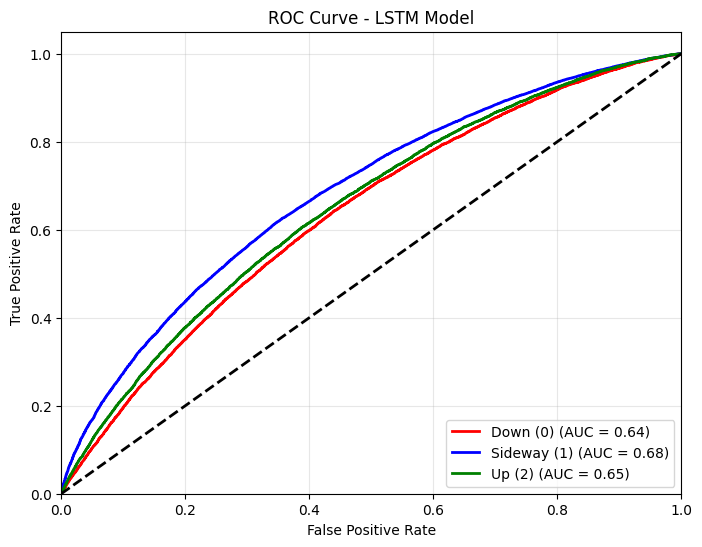

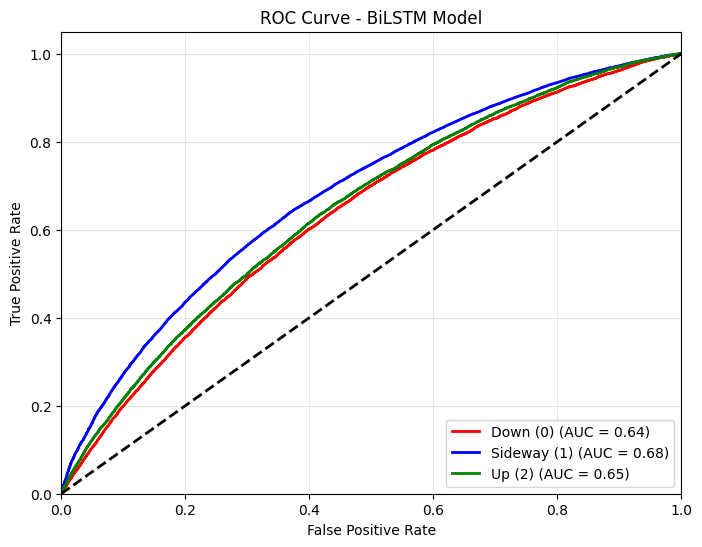

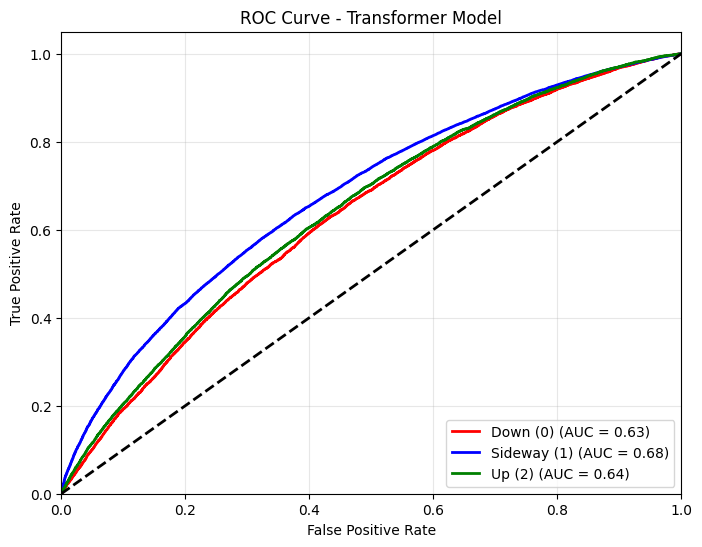

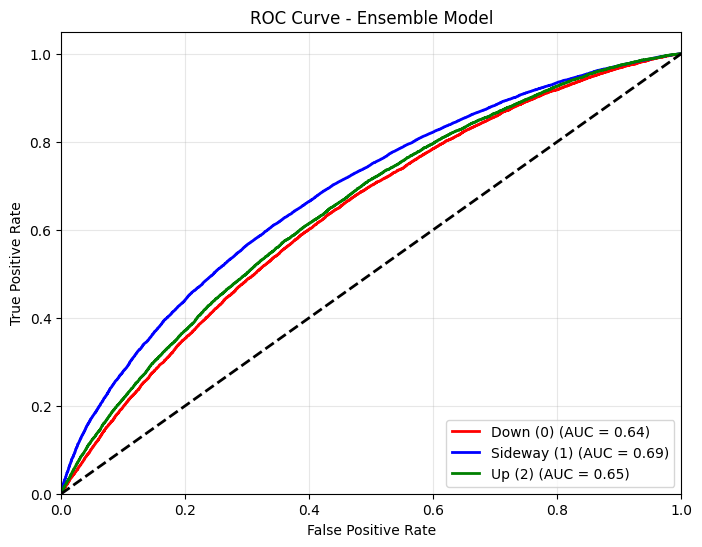

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

def plot_multiclass_roc(y_test, model_probs, model_name):

    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
    n_classes = 3

    fpr = dict()
    tpr = dict()
    roc_auc = dict()


    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], model_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])


    plt.figure(figsize=(8, 6))
    colors = ['red', 'blue', 'green']
    class_labels = ['Down (0)', 'Sideway (1)', 'Up (2)']

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2) # ড্যাশ লাইন (Random Guess)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()


plot_multiclass_roc(y_test_seq, lstm_probs, "LSTM Model")


plot_multiclass_roc(y_test_seq, bilstm_probs, "BiLSTM Model")


plot_multiclass_roc(y_test_seq, transformer_probs, "Transformer Model")


plot_multiclass_roc(y_test_seq, final_probs, "Ensemble Model")

**Model 2: Next hour Close Price Prediction**

In [2]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=05d8c033427e1eaf0cc275b038c33afa97c19e0890c35522353ac67919def3c0
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


In [3]:
import numpy as np
import pandas as pd
import ta
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


In [4]:
df = pd.read_csv("/content/drive/MyDrive/BTC_2020_2025.csv")
df = df.reset_index(drop=True)
df.head()


,timestamp,open,high,low,close,volume,transactions,vwap
0,1577836800000,7165.720000,7208.2,7136.05,7161.700000,200.991649,746,7156.5143
1,1577837400000,7163.620000,7203.9,7152.25,7190.276057,61.287264,568,7171.3307
2,1577838000000,7190.276057,7197.9,7151.60,7157.000000,181.113288,488,7179.7714
3,1577838600000,7194.200000,7200.0,7156.22,7157.300000,44.150353,395,7174.6216
4,1577839200000,7159.510000,7201.9,7153.40,7155.200000,77.830527,523,7172.0314


In [5]:
# RSI
df['rsi'] = ta.momentum.RSIIndicator(df['close'], 14).rsi()

# MACD
macd = ta.trend.MACD(df['close'])
df['macd'] = macd.macd()
df['macd_signal'] = macd.macd_signal()

# EMA
df['ema20'] = ta.trend.EMAIndicator(df['close'], 20).ema_indicator()
df['ema50'] = ta.trend.EMAIndicator(df['close'], 50).ema_indicator()

# ATR
df['atr'] = ta.volatility.AverageTrueRange(
    df['high'], df['low'], df['close'], 14
).average_true_range()

# ADX
df['adx'] = ta.trend.ADXIndicator(
    df['high'], df['low'], df['close'], 14
).adx()


df['obv'] = ta.volume.OnBalanceVolumeIndicator(df['close'], df['volume']).on_balance_volume()


indicator_bb = ta.volatility.BollingerBands(df['close'], window=20, window_dev=2)
df['bb_high'] = indicator_bb.bollinger_hband()
df['bb_low'] = indicator_bb.bollinger_lband()
df['bb_mid'] = indicator_bb.bollinger_mavg()


stoch = ta.momentum.StochasticOscillator(df['high'], df['low'], df['close'], window=14, smooth_window=3)
df['stoch_k'] = stoch.stoch()
df['stoch_d'] = stoch.stoch_signal()


df['price_change_1h'] = df['close'].pct_change(1)
df['price_change_3h'] = df['close'].pct_change(3)




df['target_next_hour'] = df['close'].shift(-1)


df.dropna(inplace=True)



In [6]:
features = [
'open', 'high', 'low', 'close', 'volume',
    'rsi', 'macd', 'macd_signal', 'ema20', 'ema50', 'atr', 'adx',
    'obv', 'bb_high', 'bb_low', 'bb_mid', 'stoch_k', 'stoch_d',
    'price_change_1h', 'price_change_3h'
]

X = df[features]
y = df['target_next_hour']


In [7]:
split = int(len(df) * 0.8)

X_train_raw = X.iloc[:split]
X_test_raw  = X.iloc[split:]

y_train = y.iloc[:split]
y_test  = y.iloc[split:]



In [8]:
from sklearn.preprocessing import MinMaxScaler


features = ['open', 'high', 'low', 'close', 'volume', 'rsi', 'macd', 'macd_signal',
            'ema20', 'ema50', 'atr', 'adx', 'obv', 'bb_high', 'bb_low', 'bb_mid',
            'stoch_k', 'stoch_d', 'price_change_1h', 'price_change_3h']




scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))


In [9]:
def create_sequences(X, y, lookback=24):
    Xs, ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i-lookback:i])
        # Modified to handle both Series (with .iloc) and NumPy arrays
        if isinstance(y, pd.Series):
            ys.append(y.iloc[i])
        else:
            ys.append(y[i])
    return np.array(Xs), np.array(ys)

# Split the X_scaled and y_scaled from Model 2's data
split = int(len(X_scaled) * 0.8)
X_train_scaled_m2 = X_scaled[:split]
X_test_scaled_m2  = X_scaled[split:]
y_train_scaled_m2 = y_scaled[:split]
y_test_scaled_m2  = y_scaled[split:]

X_train_seq, y_train_seq = create_sequences(X_train_scaled_m2, y_train_scaled_m2)
X_test_seq, y_test_seq = create_sequences(X_test_scaled_m2, y_test_scaled_m2)


In [10]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)



In [11]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Custom metric: counts prediction within ±5% of true value
def regression_accuracy(y_true, y_pred):
    return tf.reduce_mean(
        tf.cast(tf.abs(y_true - y_pred) <= 0.05 * tf.abs(y_true), tf.float32)
    )

def build_lstm(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, input_shape=input_shape),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)  # regression output
    ])

    model.compile(
        optimizer=Adam(0.001),
        loss=tf.keras.losses.Huber(),       # regression loss
        metrics=['mae', regression_accuracy]  # MAE + pseudo-accuracy
    )

    return model

# Build the model
lstm = build_lstm(X_train_seq.shape[1:])

# Train the model
history = lstm.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - loss: 0.0017 - mae: 0.0254 - regression_accuracy: 0.3951 - val_loss: 0.0017 - val_mae: 0.0577 - val_regression_accuracy: 1.5823e-04
Epoch 2/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 4.5596e-05 - mae: 0.0067 - regression_accuracy: 0.7273 - val_loss: 0.0060 - val_mae: 0.1090 - val_regression_accuracy: 0.0000e+00
Epoch 3/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 1.8497e-05 - mae: 0.0041 - regression_accuracy: 0.8233 - val_loss: 0.0066 - val_mae: 0.1142 - val_regression_accuracy: 0.0000e+00
Epoch 4/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 1.0284e-05 - mae: 0.0030 - regression_accuracy: 0.8670 - val_loss: 0.0066 - val_mae: 0.1141 - val_regression_accuracy: 0.0000e+00
Epoch 5/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 7.6697e-06 - mae: 0.0026 - regression_accuracy: 0.8883 - val_loss: 0.0066 - val_mae: 0.1145 - val_regression_accuracy: 0.0000e+00
Epoch 6/50
3549/3549 ━━━━━━━━━━━━━━━━━━

In [12]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense

# Custom regression accuracy metric (within ±5% of true value)
def regression_accuracy(y_true, y_pred):
    return tf.reduce_mean(
        tf.cast(tf.abs(y_true - y_pred) <= 0.05 * tf.abs(y_true), tf.float32)
    )

def build_bilstm(input_shape):
    model = tf.keras.Sequential([
        Bidirectional(LSTM(64), input_shape=input_shape),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1)  # regression output
    ])

    model.compile(
        optimizer=Adam(0.001),
        loss='mse',  # mean squared error for regression
        metrics=['mae', regression_accuracy]  # MAE + pseudo-accuracy
    )

    return model

# Build the model
bilstm = build_bilstm(X_train_seq.shape[1:])

# Train the model
history = bilstm.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - loss: 0.0012 - mae: 0.0187 - regression_accuracy: 0.4426 - val_loss: 2.3611e-05 - val_mae: 0.0042 - val_regression_accuracy: 0.9991
Epoch 2/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - loss: 9.1975e-05 - mae: 0.0070 - regression_accuracy: 0.7210 - val_loss: 0.0013 - val_mae: 0.0359 - val_regression_accuracy: 0.0024
Epoch 3/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - loss: 4.1593e-05 - mae: 0.0047 - regression_accuracy: 0.8063 - val_loss: 0.0083 - val_mae: 0.0903 - val_regression_accuracy: 0.0000e+00
Epoch 4/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - loss: 2.2173e-05 - mae: 0.0034 - regression_accuracy: 0.8624 - val_loss: 0.0109 - val_mae: 0.1039 - val_regression_accuracy: 0.0000e+00
Epoch 5/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - loss: 1.7625e-05 - mae: 0.0030 - regression_accuracy: 0.8857 - val_loss: 0.0101 - val_mae: 0.0999 - val_regression_accuracy: 0.0000e+00
Epoch 6/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 2

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, GlobalAveragePooling1D, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Custom regression accuracy metric (within ±5% of true value)
def regression_accuracy(y_true, y_pred):
    return tf.reduce_mean(
        tf.cast(tf.abs(y_true - y_pred) <= 0.05 * tf.abs(y_true), tf.float32)
    )

# Transformer encoder block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.2):
    x = MultiHeadAttention(
        key_dim=head_size,
        num_heads=num_heads,
        dropout=dropout
    )(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x + inputs)

    ff = Dense(ff_dim, activation="relu")(x)
    ff = Dense(inputs.shape[-1])(ff)
    x = LayerNormalization(epsilon=1e-6)(ff + x)
    return x

# Build Transformer regression model
def build_transformer(input_shape):
    inputs = Input(shape=input_shape)
    x = transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=128)
    x = GlobalAveragePooling1D()(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1)(x)  # regression output

    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(0.001),
        loss='mse',                        # mean squared error for regression
        metrics=['mae', regression_accuracy]  # MAE + pseudo-accuracy
    )
    return model

# Build and train the model
transformer = build_transformer(X_train_seq.shape[1:])
history = transformer.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - loss: 0.0046 - mae: 0.0205 - regression_accuracy: 0.5381 - val_loss: 7.4348e-05 - val_mae: 0.0076 - val_regression_accuracy: 0.9970
Epoch 2/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 3.7383e-05 - mae: 0.0047 - regression_accuracy: 0.8144 - val_loss: 1.4543e-04 - val_mae: 0.0114 - val_regression_accuracy: 0.9940
Epoch 3/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 2.8658e-05 - mae: 0.0040 - regression_accuracy: 0.8405 - val_loss: 1.7467e-05 - val_mae: 0.0031 - val_regression_accuracy: 0.9982
Epoch 4/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 2.4192e-05 - mae: 0.0037 - regression_accuracy: 0.8522 - val_loss: 3.8500e-04 - val_mae: 0.0191 - val_regression_accuracy: 0.9044
Epoch 5/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 1.8097e-05 - mae: 0.0032 - regression_accuracy: 0.8778 - val_loss: 3.7985e-04 - val_mae: 0.0190 - val_regression_accuracy: 0.9295
Epoch 6/50
3549/3549 ━━━━━━━━━━━━━━━━━━━━ 9

In [14]:
lstm_pred = lstm.predict(X_test_seq)
bilstm_pred = bilstm.predict(X_test_seq)
transformer_pred = transformer.predict(X_test_seq)

final_pred = (lstm_pred + bilstm_pred + transformer_pred) / 3


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report
import numpy as np


predictions = {
    'LSTM': lstm_pred,
    'BiLSTM': bilstm_pred,
    'Transformer': transformer_pred,
    'Ensemble': final_pred
}


for name, pred in predictions.items():
    mae = mean_absolute_error(y_test_seq, pred)
    rmse = np.sqrt(mean_squared_error(y_test_seq, pred))
    r2 = r2_score(y_test_seq, pred)

    print(f"--- {name} Regression Stats ---")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2 Score: {r2:.4f}")
    print("-" * 30)

def get_direction_metrics(y_true, y_pred, current_prices):
    # Inverse transform y_true and y_pred to original scale
    y_true_unscaled = scaler_y.inverse_transform(y_true)
    y_pred_unscaled = scaler_y.inverse_transform(y_pred)

    actual_dir = (y_true_unscaled > current_prices).astype(int)
    pred_dir = (y_pred_unscaled > current_prices).astype(int)

    return classification_report(actual_dir, pred_dir, target_names=['Price Down', 'Price Up'])

lookback=24

# The original 'df' had 315552 rows before dropna for Model 2. After dropna for features, it became 315502 rows.
# The 'split' is 0.8 of the number of rows after feature engineering and dropna.
# y_test_seq corresponds to scaled target_next_hour values starting from index `split + lookback` in the original `y` series.
# So, the current prices for comparison should be the `close` prices at index `split + lookback + k` for each `y_test_seq[k]`.
current_prices = df['close'].iloc[split + lookback : split + lookback + len(y_test_seq)].values.reshape(-1, 1)

for name, pred in predictions.items():
    print(f"--- {name} Directional Report ---")
    print(get_direction_metrics(y_test_seq, pred, current_prices))
    print("=" * 40)

1971/1971 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
--- LSTM Regression Stats ---
MAE: 0.0780
RMSE: 0.0790
R2 Score: 0.4437
------------------------------
--- BiLSTM Regression Stats ---
MAE: 0.0416
RMSE: 0.0498
R2 Score: 0.7786
------------------------------
--- Transformer Regression Stats ---
MAE: 0.0823
RMSE: 0.0933
R2 Score: 0.2243
------------------------------
--- Ensemble Regression Stats ---
MAE: 0.0673
RMSE: 0.0727
R2 Score: 0.5291
------------------------------
--- LSTM Directional Report ---
              precision    recall  f1-score   support

  Price Down       0.50      1.00      0.67     31517
    Price Up       1.00      0.00      0.00     31550

    accuracy                           0.50     63067
   macro avg       0.75      0.50      0.33     63067
weighted avg       0.75      0.50      0.33     63067

--- BiLSTM Directional Report ---
              precision    recall  f1-score   support

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Cross-Asset Analysis:**

Data merge

In [16]:
# ==============================
# 1️⃣ Imports
# ==============================
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, mean_squared_error, mean_absolute_error

# ==============================
# 2️⃣ Load Data
# ==============================
btc_df = pd.read_csv("/content/drive/MyDrive/BTC_2020_2025.csv")
eth_df = pd.read_csv("/content/drive/MyDrive/ETH_2020_2025.csv")

eth_df['timestamp'] = pd.to_datetime(eth_df['timestamp'])
btc_df['timestamp'] = pd.to_datetime(btc_df['timestamp'])
df = eth_df.merge(btc_df, on='timestamp', suffixes=('_eth', '_btc'))

# ==============================
# 3️⃣ Feature Engineering
# ==============================
def add_indicators(df, prefix):
    df[f'{prefix}_ema10'] = df[f'close_{prefix}'].ewm(span=10).mean()
    df[f'{prefix}_ema20'] = df[f'close_{prefix}'].ewm(span=20).mean()

    delta = df[f'close_{prefix}'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / (avg_loss + 1e-9)
    df[f'{prefix}_rsi'] = 100 - (100 / (1 + rs))
    return df

df = add_indicators(df, 'eth')
df = add_indicators(df, 'btc')

df['eth_return'] = df['close_eth'].pct_change()
df['btc_return'] = df['close_btc'].pct_change()

df['eth_direction'] = (df['eth_return'].shift(-1) > 0).astype(int)

df.dropna(inplace=True)

feature_cols = [col for col in df.columns if any(x in col for x in ['ema','rsi','return'])]
X = df[feature_cols].values
y_reg = df['eth_return'].values
y_clf = df['eth_direction'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

# ==============================
# 4️⃣ Dataset
# ==============================
class CryptoDataset(Dataset):
    def __init__(self, X, y_reg, y_clf, seq_len=20):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y_reg = torch.tensor(y_reg, dtype=torch.float32)
        self.y_clf = torch.tensor(y_clf, dtype=torch.long)
        self.seq_len = seq_len

    def __len__(self):
        return len(self.X) - self.seq_len

    def __getitem__(self, idx):
        return (
            self.X[idx:idx+self.seq_len],
            self.y_reg[idx+self.seq_len],
            self.y_clf[idx+self.seq_len]
        )

SEQ_LEN = 20
dataset = CryptoDataset(X, y_reg, y_clf, SEQ_LEN)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# ==============================
# 5️⃣ Transformer Model
# ==============================
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=4, num_layers=2, dropout=0.2):
        super().__init__()

        self.input_projection = nn.Linear(input_dim, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=256,
            dropout=dropout,
            batch_first=True
        )

        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)

        self.dropout = nn.Dropout(dropout)
        self.reg_head = nn.Linear(d_model, 1)
        self.clf_head = nn.Linear(d_model, 2)

    def forward(self, x):
        x = self.input_projection(x)
        x = self.transformer(x)
        x = x[:, -1, :]   # last timestep
        x = self.dropout(x)
        reg_out = self.reg_head(x)
        clf_out = self.clf_head(x)
        return reg_out.squeeze(), clf_out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerModel(X.shape[1]).to(device)

# ==============================
# 6️⃣ Loss & Optimizer
# ==============================
criterion_reg = nn.MSELoss()
criterion_clf = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)

# ==============================
# 7️⃣ Training
# ==============================
EPOCHS = 30

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0

    for X_batch, y_r, y_c in train_loader:
        X_batch, y_r, y_c = X_batch.to(device), y_r.to(device), y_c.to(device)

        optimizer.zero_grad()
        out_r, out_c = model(X_batch)

        loss = criterion_reg(out_r, y_r) + criterion_clf(out_c, y_c)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation
    model.eval()
    y_true_reg, y_pred_reg = [], []
    y_true_clf, y_pred_clf = [], []
    val_loss = 0

    with torch.no_grad():
        for X_batch, y_r, y_c in val_loader:
            X_batch, y_r, y_c = X_batch.to(device), y_r.to(device), y_c.to(device)
            out_r, out_c = model(X_batch)

            loss = criterion_reg(out_r, y_r) + criterion_clf(out_c, y_c)
            val_loss += loss.item()

            y_true_reg.extend(y_r.cpu().numpy())
            y_pred_reg.extend(out_r.cpu().numpy())
            y_true_clf.extend(y_c.cpu().numpy())
            y_pred_clf.extend(torch.argmax(out_c, 1).cpu().numpy())

    rmse = np.sqrt(mean_squared_error(y_true_reg, y_pred_reg))
    mae = mean_absolute_error(y_true_reg, y_pred_reg)
    f1 = f1_score(y_true_clf, y_pred_clf, average='macro')

    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} | RMSE: {rmse:.6f} | MAE: {mae:.6f} | Macro F1: {f1:.4f}")


Epoch 1/30 | RMSE: 0.003995 | MAE: 0.002438 | Macro F1: 0.4567
Epoch 2/30 | RMSE: 0.004470 | MAE: 0.003138 | Macro F1: 0.5165
Epoch 3/30 | RMSE: 0.003870 | MAE: 0.002285 | Macro F1: 0.3570
Epoch 4/30 | RMSE: 0.003870 | MAE: 0.002267 | Macro F1: 0.5153
Epoch 5/30 | RMSE: 0.003857 | MAE: 0.002256 | Macro F1: 0.3440
Epoch 6/30 | RMSE: 0.004008 | MAE: 0.002525 | Macro F1: 0.5145
Epoch 7/30 | RMSE: 0.003865 | MAE: 0.002275 | Macro F1: 0.5154
Epoch 8/30 | RMSE: 0.003861 | MAE: 0.002268 | Macro F1: 0.5157
Epoch 9/30 | RMSE: 0.003869 | MAE: 0.002267 | Macro F1: 0.5158
Epoch 10/30 | RMSE: 0.003871 | MAE: 0.002292 | Macro F1: 0.5162
Epoch 11/30 | RMSE: 0.003858 | MAE: 0.002261 | Macro F1: 0.5166
Epoch 12/30 | RMSE: 0.003858 | MAE: 0.002264 | Macro F1: 0.5165
Epoch 13/30 | RMSE: 0.003858 | MAE: 0.002263 | Macro F1: 0.5165
Epoch 14/30 | RMSE: 0.003855 | MAE: 0.002255 | Macro F1: 0.5165
Epoch 15/30 | RMSE: 0.003855 | MAE: 0.002256 | Macro F1: 0.5165
Epoch 16/30 | RMSE: 0.003855 | MAE: 0.002255 | Ma


FINAL PERFORMANCE REPORT

--- Classification Report (Up/Down Prediction) ---
              precision    recall  f1-score   support

        Down       0.51      0.49      0.50     31323
          Up       0.52      0.55      0.53     31771

    accuracy                           0.52     63094
   macro avg       0.52      0.52      0.52     63094
weighted avg       0.52      0.52      0.52     63094



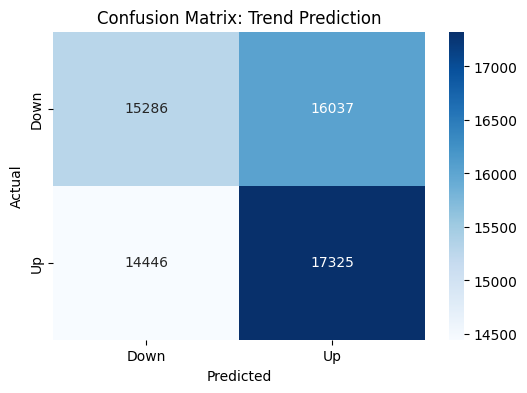

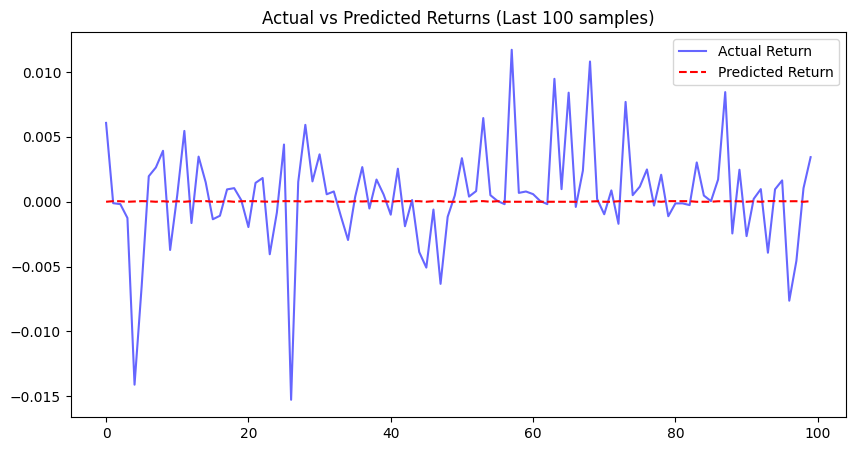

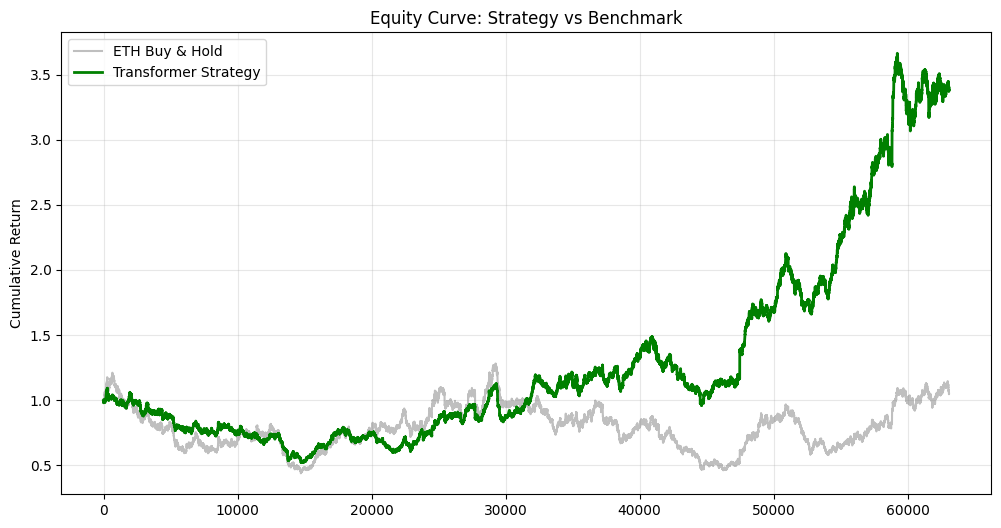


--- Strategy Risk Metrics ---
Max Drawdown: -52.44%
Final Strategy Value: 3.3813
Final ETH Value: 1.0483


In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# ==============================
# 8️⃣ Performance Analysis Report
# ==============================

print("\n" + "="*30)
print("FINAL PERFORMANCE REPORT")
print("="*30)

# 1. Classification Metrics
print("\n--- Classification Report (Up/Down Prediction) ---")
print(classification_report(y_true_clf, y_pred_clf, target_names=['Down', 'Up']))

# 2. Confusion Matrix Heatmap
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_true_clf, y_pred_clf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.title("Confusion Matrix: Trend Prediction")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 3. Regression Visualization (Actual vs Predicted Returns)
plt.figure(figsize=(10, 5))
plt.plot(y_true_reg[:100], label='Actual Return', color='blue', alpha=0.6)
plt.plot(y_pred_reg[:100], label='Predicted Return', color='red', linestyle='--')
plt.title("Actual vs Predicted Returns (Last 100 samples)")
plt.legend()
plt.show()

# 4. Trading Strategy Simulation (Equity Curve)

results_df = pd.DataFrame({
    'actual_ret': y_true_reg,
    'pred_direction': y_pred_clf
})


results_df['strategy_ret'] = results_df['pred_direction'] * results_df['actual_ret']


results_df['cum_eth'] = (1 + results_df['actual_ret']).cumprod()
results_df['cum_strategy'] = (1 + results_df['strategy_ret']).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(results_df['cum_eth'], label='ETH Buy & Hold', color='gray', alpha=0.5)
plt.plot(results_df['cum_strategy'], label='Transformer Strategy', color='green', linewidth=2)
plt.title("Equity Curve: Strategy vs Benchmark")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 5. Risk Analysis (Drawdown)
cum_ret = results_df['cum_strategy']
running_max = cum_ret.cummax()
drawdown = (cum_ret - running_max) / running_max
max_dd = drawdown.min()

print(f"\n--- Strategy Risk Metrics ---")
print(f"Max Drawdown: {max_dd*100:.2f}%")
print(f"Final Strategy Value: {results_df['cum_strategy'].iloc[-1]:.4f}")
print(f"Final ETH Value: {results_df['cum_eth'].iloc[-1]:.4f}")